In [ ]:
%pip install langgraph langchain-openai langchain-chroma langchain-community python-dotenv

# Build a basic agent
- 질문에 답하고 도구를 호출할 수 있는 간단한 에이전트를 만드는 것부터 시작하세요. 에이전트는 언어 모델로 gpt-4o-mini를 사용하고, 도구로 기본적인 날씨 함수를 사용하며, 간단한 프롬프트를 통해 동작을 안내합니다.

In [17]:
from langchain.agents import create_agent
import pprint
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

agent = create_agent(
    model="gpt-4o-mini",
    tools=[get_weather],
    system_prompt="You are a helpful assistant, please answer korean."
)

# Run the agent
answer = agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)
pprint.pprint(answer)

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='54e9cc19-511f-4d84-bd2e-6a69bbfd27ab'),
              AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 60, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYnVJmhnGQgcmaZntVb4lwN41fAGt', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--3f58bf45-543a-454e-b551-cca7975a8ced-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'San Francisco'}, 'id': 'call_gex7Iulo2fFPWoyHRJmCaqSY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 60, 'output_tokens

In [ ]:
create_agent(
    model: str | BaseChatModel,
    tools: Sequence[BaseTool | Callable | dict[str, Any]] | None = None,
    *,
    system_prompt: str | None = None,
    middleware: Sequence[AgentMiddleware[StateT_co, ContextT]] = (),
    response_format: ResponseFormat[ResponseT] | type[ResponseT] | None = None,
    state_schema: type[AgentState[ResponseT]] | None = None,
    context_schema: type[ContextT] | None = None,
    checkpointer: Checkpointer | None = None,
    store: BaseStore | None = None,
    interrupt_before: list[str] | None = None,
    interrupt_after: list[str] | None = None,
    debug: bool = False,
    name: str | None = None,
    cache: BaseCache | None = None,
) -> CompiledStateGraph[
    AgentState[ResponseT], ContextT, _InputAgentState, _OutputAgentState[ResponseT]
]

## 시스템 프롬프트정의
- 시스템 프롬프트는 상담원의 역할과 행동을 정의합니다. 구체적이고 실행 가능한 메세지를 작성하세요.

In [25]:
SYSTEM_PROMPT = """You are an expert weather forecaster, who speaks in puns.
                   you always have to speak in korean.
You have access to two tools:

- get_weather_for_location: use this to get the weather for a specific location
- get_user_location: use this to get the user's location

If a user asks you for the weather, make sure you know the location. 
If you can tell from the question that they mean wherever they are, 
use the get_user_location tool to find their location."""

## 도구 만들기
- 도구는 사용자가 정의한 함수를 호출하여 모델이 외부 시스템과 상호 작용할 수 있도록 합니다. 
- 도구는 런타임 컨텍스트 에 따라 달라질 수 있으며, 에이전트 메모리 와도 상호 작용할 수 있습니다 .
- 아래에서 get_user_location도구가 런타임 컨텍스트를 사용하는 방법을 확인하세요.

In [ ]:
# 표준 라이브러리 dataclasses에서 dataclass 데코레이터를 가져옵니다.
# 왜? - 간단한 데이터 보관용 클래스(런타임 컨텍스트 등)를 보일러플레이트 없이 정의하기 위해.
from dataclasses import dataclass

# LangChain의 Tool 관련 유틸을 불러옵니다.
# @tool: 일반 파이썬 함수를 에이전트가 호출할 수 있는 "도구"로 래핑해주는 데코레이터
# ToolRuntime: 툴 실행 시 주입되는 실행 컨텍스트(사용자 정의 타입으로 제네릭 지정 가능)
from langchain.tools import tool, ToolRuntime


# === Tool 1: 날씨 조회 ===
@tool
def get_weather_for_location(city: str) -> str:
    """
    이 툴의 문서 문자열(docstring).
    왜? - LangChain이 툴의 설명(description)으로 활용하여 LLM이 '언제/어떻게' 써야 할지 힌트를 줌.
    내용: '특정 도시의 날씨를 알려준다'는 목적을 명시.
    """
    # 함수 인자: city (str)
    # 왜? - LLM이 툴을 호출할 때 JSON 인자를 생성하므로, 명확한 타입 힌팅/이름이 매우 중요.
    return f"It's always sunny in {city}!"
    # 반환: 간단한 문자열 응답 (데모용)
    # 실제 구현에선 외부 API 호출/캐시/에러처리 등을 수행할 수 있음.
    # 흐름: 에이전트 -> (툴콜 결심) -> get_weather_for_location(city=...) 실행 -> 문자열 결과를 ToolMessage로 메시지 스택에 추가.


# === 런타임 컨텍스트 정의 ===
@dataclass
class Context:
    """
    사용자 정의 '런타임 컨텍스트' 스키마.
    왜 dataclass? - 가볍고 불변성/타입힌트가 명시적인 컨테이너를 쉽게 정의.
    여기서는 user_id 하나만 담지만, 실전에서는 권한정보, 세션, 테넌트, 지역(locale) 등 확장 가능.
    """
    user_id: str  # 이 컨텍스트가 가지고 다닐 정보(예: 인증된 사용자 ID)


# === Tool 2: 컨텍스트를 읽는 툴 ===
@tool
def get_user_location(runtime: ToolRuntime[Context]) -> str:
    """
    이 툴은 '런타임 컨텍스트'를 입력으로 받습니다.
    왜? - 툴 실행 시점에 시스템이 주입한 Context(예: user_id)를 참조하여
          사용자 맞춤 동작을 수행하려고.
    문서 문자열은 LLM에게 '이 툴은 user_id 기반 사용자 정보를 조회'한다는 사용 의도를 제공합니다.
    """
    # ToolRuntime[Context]: 툴 호출 당시의 실행 환경 + context를 접근하게 해줌.
    # 제네릭에 우리가 정의한 Context 타입을 넣어, runtime.context 속성의 타입을 안정적으로 보장.
    user_id = runtime.context.user_id
    # 컨텍스트에서 user_id를 꺼내 비즈니스 로직에 활용.
    # 여기선 데모로 user_id == "1"이면 Florida, 아니면 SF 반환.
    return "Florida" if user_id == "1" else "SF"
    # 흐름: 에이전트(혹은 그래프)가 실행시 ToolRuntime(Context(user_id="..."))를 주입
    #   -> 툴 내부에서 runtime.context.user_id 사용
    #   -> 컨텍스트 기반 결과를 계산해 문자열 반환.


"""
도구는 잘 문서화되어야 합니다. 
도구의 이름, 설명, 인수 이름은 모델 프롬프트의 일부가 됩니다. 
LangChain의 @tool데코레이터는 메타데이터를 추가하고 
ToolRuntime매개변수를 통한 런타임 주입을 활성화합니다.
"""

"""
이 ToolRuntime 클래스는 LangChain/LangGraph에서 툴(tool) 실행 시 
필요한 런타임 정보를 하나의 객체로 통합해서 자동으로 넘겨주는 역할을 합니다.
툴 함수가 tool_runtime 또는 runtime: ToolRuntime 을 파라미터로 받으면, 
LangChain 시스템이 내부적으로 상태, 컨텍스트, 실행 설정, 스트림 메시지, 스토리지, 실행 ID 등을 자동 주입합니다.

주요 필드 설명
state: 현재 그래프의 상태 (예: 대화 메시지, 캐시, 카운터 등 툴 실행 도중 변하는 값 저장)

context: 런타임 컨텍스트 (예: 유저 아이디, 세션 정보, 실행 환경 등)

config: 개별 실행을 위한 설정 정보 (RunnableConfig), 예를 들어 실행 ID, 리트라이 정책 등

stream_writer: 툴 실행 중 실시간으로 메시지나 상태 업데이트를 스트리밍하는 객체

tool_call_id: 이번 툴 호출의 고유 ID (트래킹, 로깅 등에 사용)

store: 장기적 데이터를 저장하는 객체 (BaseStore), 예를 들어 유저 장기 메모리 등

사용 예시
툴 함수에서 runtime: ToolRuntime 타입으로 인자를 받으면

대화 상태, 스트림 메시지, 사용자 정보 등의 런타임 데이터를 쉽게 사용할 수 있다.

코드는 파라미터 이름만 맞추면 되고, 별도 어노테이션이나 래퍼가 필요 없음.

즉, 툴 함수 내에서 여러 종류의 런타임 데이터를 쉽게 접근하고 처리할 수 있게 자동화된 편리한 툴 인젝션 구조입니다.
"""

'\n도구는 잘 문서화되어야 합니다. \n도구의 이름, 설명, 인수 이름은 모델 프롬프트의 일부가 됩니다. \nLangChain의 @tool데코레이터는 메타데이터를 추가하고 \nToolRuntime매개변수를 통한 런타임 주입을 활성화합니다.\n'

## 모델 구성
- 사용 사례에 맞는 올바른 매개변수로 언어 모델을 설정하세요

In [23]:
from langchain.chat_models import init_chat_model

model = init_chat_model(
    model="gpt-4o-mini",
    temperature=0.2,
    max_tokens=1000,
)

## 응답 형식 정의
- 선택적으로, 에이전트 응답이 특정 스키마와 일치해야 하는 경우 구조화된 응답 형식을 정의합니다.

In [24]:
from dataclasses import dataclass
# 왜: 가벼운 데이터 컨테이너를 쉽게 정의하려고 dataclass 사용.
#     필드 타입힌트만 쓰면 __init__/__repr__/__eq__ 등을 자동 생성해 주므로
#     "응답 형태(스키마)"를 간단히 선언하기에 적합.
#     (주석에 적었듯 Pydantic 모델도 지원되므로, 검증이 더 필요하면 Pydantic으로 바꿔도 됨)

# We use a dataclass here, but Pydantic models are also supported.
@dataclass
class ResponseFormat:
    """Response schema for the agent."""
    # 왜: 이 클래스는 "에이전트가 어떤 형식으로 답을 내야 하는가"를 정의하는 '응답 스키마' 역할.
    # 흐름: create_agent(response_format=ResponseFormat) → LLM 출력이 이 구조에 맞추어 생성/파싱.

    # A punny response (always required)
    punny_response: str
    # 무엇: '항상 필요한' 필드(필수). 말장난(pun)이 들어간 한 줄 응답을 문자열로 요구.
    # 왜: 모델이 반드시 이 필드를 채우게 해서 프롬프트 의도를 강제하고, 
    #     후속 코드가 이 값을 신뢰하고 사용 가능(널 체크 없이).

    # Any interesting information about the weather if available
    weather_conditions: str | None = None
    # 무엇: 선택(optional) 필드. 날씨 관련 흥미로운 정보가 있으면 문자열로, 없으면 None.
    # 왜: 상황에 따라 정보가 없을 수 있으므로 기본값을 None으로 두어 "선택 필드"임을 명확히.


In [27]:
"""이 스키마가 어디서 어떻게 쓰이나? (흐름)

에이전트 생성 시 연결

graph = create_agent(
    model="anthropic:claude-sonnet-4-5",
    tools=[...],
    response_format=ResponseFormat,  # ← 여기!
)


LangChain이 LLM에게 “응답을 이 구조로 내놔”라고 유도합니다(모델 능력에 따라 JSON/함수호출 등으로).

실행 → 구조화 응답 파싱

모델이 생성한 출력을 LangChain이 ResponseFormat에 매핑/검증합니다.

punny_response는 반드시 채워져야 하고, weather_conditions는 비어 있어도 됩니다.

후속 처리 안정성↑

이후 코드에서 result.punny_response를 널체크 없이 바로 사용해도 안전.

weather_conditions는 if result.weather_conditions: 처럼 선택적으로 활용.

왜 dataclass? vs Pydantic?

dataclass

가볍고 빠르며 표준 라이브러리. “형태 선언” 중심이라 데모/간단 스키마에 적합.

Pydantic

엄격한 유효성 검증, 변환, 에러 메시지가 필요하면 더 적합.

예: 날짜/이메일/Enum, 커스텀 검증 로직 등.

동일 스키마를 Pydantic으로 쓰면:

from pydantic import BaseModel, Field

class ResponseFormat(BaseModel):
    punny_response: str = Field(..., description="말장난 한 줄 응답(필수)")
    weather_conditions: str | None = Field(None, description="있으면 날씨 정보")

미니 사용 예 (LangChain 에이전트)
from langchain.agents import create_agent

graph = create_agent(
    model="anthropic:claude-sonnet-4-5",
    tools=[],
    response_format=ResponseFormat,  # ← 구조화 응답 스키마
    system_prompt="Always respond with a pun, and include weather info if helpful."
)

out = graph.invoke({"messages": [{"role": "user", "content": "오늘 기분 어때?"}]})
# LangChain이 내부적으로 ResponseFormat에 맞춰 파싱/검증해 반환
# (반환 형태는 실행 컨텍스트/버전에 따라 dict 또는 객체일 수 있음) 
"""

'이 스키마가 어디서 어떻게 쓰이나? (흐름)\n\n에이전트 생성 시 연결\n\ngraph = create_agent(\n    model="anthropic:claude-sonnet-4-5",\n    tools=[...],\n    response_format=ResponseFormat,  # ← 여기!\n)\n\n\nLangChain이 LLM에게 “응답을 이 구조로 내놔”라고 유도합니다(모델 능력에 따라 JSON/함수호출 등으로).\n\n실행 → 구조화 응답 파싱\n\n모델이 생성한 출력을 LangChain이 ResponseFormat에 매핑/검증합니다.\n\npunny_response는 반드시 채워져야 하고, weather_conditions는 비어 있어도 됩니다.\n\n후속 처리 안정성↑\n\n이후 코드에서 result.punny_response를 널체크 없이 바로 사용해도 안전.\n\nweather_conditions는 if result.weather_conditions: 처럼 선택적으로 활용.\n\n왜 dataclass? vs Pydantic?\n\ndataclass\n\n가볍고 빠르며 표준 라이브러리. “형태 선언” 중심이라 데모/간단 스키마에 적합.\n\nPydantic\n\n엄격한 유효성 검증, 변환, 에러 메시지가 필요하면 더 적합.\n\n예: 날짜/이메일/Enum, 커스텀 검증 로직 등.\n\n동일 스키마를 Pydantic으로 쓰면:\n\nfrom pydantic import BaseModel, Field\n\nclass ResponseFormat(BaseModel):\n    punny_response: str = Field(..., description="말장난 한 줄 응답(필수)")\n    weather_conditions: str | None = Field(None, description="있으면 날씨 정보")\n\n미니 사용 예 (LangChain 에이전트)\nfrom langchain.agents import create_ag

## 메모리 추가
- 에이전트에 **메모리**를 추가하여 상호작용 전반의 상태를 유지하세요
- 이를 통해 에이전트는 이전 대화와 맥락을 기억할 수 있습니다.

In [28]:
from langgraph.checkpoint.memory import InMemorySaver
# 무엇: LangGraph의 "체크포인트 저장소" 구현 중 하나를 임포트.
# 왜: 그래프 실행 중간중간의 상태(state)를 메모리에 저장해서
#     재시작(재진입)하거나, 스트리밍 중간 결과를 이어받을 수 있게 하기 위해.
#     (= 대화 메모리/히스토리, interrupt 후 재개 등을 가능하게 하는 핵심 컴포넌트)

checkpointer = InMemorySaver()
# 무엇: 프로세스 메모리에 상태를 저장하는 체크포인터 인스턴스 생성.
# 왜: 빠르고 설정이 간단함. 데모/개발/단일 프로세스 환경에서 유용.
#    단, 프로세스가 내려가면(서버 재시작) 저장 내용이 사라짐 → 영속성은 없음.


In [29]:
"""
체크포인터가 정확히 뭔가요?

LangGraph는 노드 간 **상태(State)**를 전달하며 실행됩니다.

체크포인터는 이 상태 스냅샷을 특정 타이밍(노드 끝, interrupt 시점 등)에 저장해 둡니다.

이렇게 저장된 상태는 나중에 같은 thread_id(대화 세션/작업 ID)로 다시 불러와 재개할 수 있어요.

예) interrupt()로 사람이 승인할 때까지 멈춤 → 승인이 오면 그 시점 상태에서 Command(resume=...)로 이어가기

InMemorySaver의 특징 (장단점)

✅ 장점

설정이 제일 간단하고 빠름(로컬 메모리 dict 수준).

테스트/개발/단일 인스턴스 PoC에 최적.

⚠️ 단점

프로세스 재기동/크래시 시 데이터 소실.

여러 서버(멀티 인스턴스)에서 공유 불가.

상태가 커지면 메모리 사용량 증가 → 관리 필요.

운영/배포에서는 보통 SqliteSaver, PostgresSaver 같은 영속 저장소를 써요. 그래야 서버 재시작이나 스케일아웃에서도 대화/작업 상태가 유지됩니다.

어떻게 연결하나요? (미니 예시)
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, add_messages, END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt, Command

# 1) 상태 스키마 정의
class S(TypedDict):
    messages: Annotated[list, add_messages]
    approved: bool | None

# 2) 노드 정의
def draft(state: S):
    return {"messages": [{"role":"ai","content":"초안 v1"}]}

def review(state: S):
    # 중요 지점: 사람 승인을 받아야 하므로 여기서 중단
    _ = interrupt({"reason":"need_approval", "draft":"초안 v1"})
    # resume 값이 들어오면 계속 실행
    return {}

def maybe_end(state: S):
    return END

# 3) 그래프 구성
builder = StateGraph(S)
builder.add_node("draft", draft)
builder.add_node("review", review)
builder.add_node("maybe_end", maybe_end)
builder.add_edge("draft", "review")
builder.add_edge("review", "maybe_end")
builder.set_entry_point("draft")

# 4) 체크포인터 주입 (여기가 핵심)
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# 5) 실행 (thread_id는 같은 대화/작업을 식별)
thread = {"configurable": {"thread_id": "brand-001"}}

# 첫 실행: review에서 interrupt로 멈춤 → UI/서버가 payload를 수신
events = graph.stream({"messages":[{"role":"user","content":"브리프 만들어줘"}]}, thread)
for ev in events:
    print(ev)  # 여기서 interrupt 신호를 받음

# 사용자가 승인했다고 가정 → 재개
graph.invoke(Command(resume={"approve": True}), thread)

흐름 정리

compile(checkpointer=InMemorySaver())로 그래프가 상태 저장 지원을 갖추게 됩니다.

stream/invoke 호출 시 thread_id로 세션을 식별해 같은 대화/작업의 상태를 찾아 씁니다.

interrupt()를 만나면 상태를 저장하고 정지 → 외부에서 승인/수정값을 받아 Command(resume=...)로 같은 지점부터 계속.

언제 InMemorySaver를 쓸까?

튜토리얼/데모/개발 단계

단일 프로세스(로컬, 노트북, 한 개의 uvicorn worker)에서 빠르게 테스트

상태 유실되어도 괜찮은 임시 워크플로

언제 다른 Saver가 필요할까?

서버 재시작 후에도 세션을 이어가야 함

여러 인스턴스(오토스케일)에서 같은 세션을 이어가야 함

대용량 상태(리서치 캐시, 검색 결과 등)를 안정적으로 관리해야 함

이럴 때는 파일/DB 기반 체크포인터를 고려하세요(예: SQLite, Postgres).
또한 LangGraph의 store(전역 데이터 저장)와 함께 쓰면 여러 스레드/유저 간 공유 데이터도 다룰 수 있습니다.

한 줄 요약

InMemorySaver()는 그래프 상태를 RAM에 저장하는 초간단 체크포인터예요.
빠른 개발/테스트용으로 최고지만, 영속성/확장성이 필요하면 DB 기반 Saver로 바꾸세요.
"""

'\n체크포인터가 정확히 뭔가요?\n\nLangGraph는 노드 간 **상태(State)**를 전달하며 실행됩니다.\n\n체크포인터는 이 상태 스냅샷을 특정 타이밍(노드 끝, interrupt 시점 등)에 저장해 둡니다.\n\n이렇게 저장된 상태는 나중에 같은 thread_id(대화 세션/작업 ID)로 다시 불러와 재개할 수 있어요.\n\n예) interrupt()로 사람이 승인할 때까지 멈춤 → 승인이 오면 그 시점 상태에서 Command(resume=...)로 이어가기\n\nInMemorySaver의 특징 (장단점)\n\n✅ 장점\n\n설정이 제일 간단하고 빠름(로컬 메모리 dict 수준).\n\n테스트/개발/단일 인스턴스 PoC에 최적.\n\n⚠️ 단점\n\n프로세스 재기동/크래시 시 데이터 소실.\n\n여러 서버(멀티 인스턴스)에서 공유 불가.\n\n상태가 커지면 메모리 사용량 증가 → 관리 필요.\n\n운영/배포에서는 보통 SqliteSaver, PostgresSaver 같은 영속 저장소를 써요. 그래야 서버 재시작이나 스케일아웃에서도 대화/작업 상태가 유지됩니다.\n\n어떻게 연결하나요? (미니 예시)\nfrom typing import TypedDict, Annotated\nfrom langgraph.graph import StateGraph, add_messages, END\nfrom langgraph.checkpoint.memory import InMemorySaver\nfrom langgraph.types import interrupt, Command\n\n# 1) 상태 스키마 정의\nclass S(TypedDict):\n    messages: Annotated[list, add_messages]\n    approved: bool | None\n\n# 2) 노드 정의\ndef draft(state: S):\n    return {"messages": [{"role":"ai","content":"초안 v1"}]}\n\ndef review(s

## 에이전트를 생성하고 실행합니다.
- 모든 구성 요소를 사용해 에이전트를 조립하고 실행해 보세요!

In [37]:
# 에이전트(그래프) 생성
agent = create_agent(
    model=model,                           # 무엇: 사용할 LLM (예: ChatOpenAI/Anthropic 등 인스턴스 또는 문자열 식별자)
    system_prompt=SYSTEM_PROMPT,           # 왜: 대화 전반의 행동 정책/톤을 지정(시스템 메세지로 선반영)
    tools=[get_user_location, get_weather_for_location],  # 무엇: LLM이 호출할 수 있는 도구 목록(위에서 @tool로 등록)
    context_schema=Context,                # 왜: ToolRuntime에 주입되는 "런타임 컨텍스트"의 스키마(데이터 형태)를 명시
    response_format=ResponseFormat,        # 왜: 에이전트의 "구조화 응답 스키마" 지정(필수/옵션 필드, 타입)
    checkpointer=checkpointer              # 왜: 대화 상태를 저장/복구(메모리 또는 DB). 같은 thread_id로 이어붙이기 가능
)

# thread_id: 한 "대화/세션"을 식별하는 고유 값
config = {"configurable": {"thread_id": "1"}}
# 왜: 동일한 thread_id를 쓰면, 같은 대화 히스토리/상태가 이어짐(메모리/체크포인터 이용)

# --- 1차 호출: "밖 날씨 어때?" ---
response = agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather outside?"}]},
    config=config,                # 무엇: 위에서 정의한 thread_id 설정(상태 이어받기)
    context=Context(user_id="1")  # 흐름: 실행 시 ToolRuntime에 주입될 컨텍스트(여기선 user_id만 포함)
)

# 흐름 요약:
#  1) LLM이 메시지/시스템 프롬프트를 보고 목적 판단
#  2) 도구 호출 필요 판단 → get_user_location(runtime) 호출(컨텍스트로 user_id="1")
#  3) 위치 "Florida" 반환 → 이어서 get_weather_for_location(city="Florida") 호출
#  4) 두 툴 결과를 바탕으로 LLM이 ResponseFormat 스키마에 맞게 structured_response 생성

print(response['structured_response'])
# 무엇: LangChain이 response_format에 맞춰 파싱한 "구조화 응답"
# 형태: ResponseFormat(punny_response=..., weather_conditions=...)
# 장점: 이후 로직에서 키 안전하게 접근(널/형 변환 오류 감소)


# --- 같은 thread_id로 대화를 계속 ---
response = agent.invoke(
    {"messages": [{"role": "user", "content": "thank you!"}]},
    config=config,                # 동일 thread_id → 같은 히스토리/상태를 활용
    context=Context(user_id="1")  # 컨텍스트 계속 주입(필요 시 사용자/권한/테넌트 등 바꿔도 됨)
)
# 흐름:
#  - 이전 턴에서 쌓인 메시지/도구 결과를 기억한 채(체크포인터) 응답
#  - 이번에는 날씨 도구 호출이 필요 없으니 punny_response만 채우고 weather_conditions는 None일 수 있음

print(response['structured_response'])

print(type(response))
print(response.keys())

msgs = response.get("messages", [])
last = msgs[-1] if msgs else None
if last:
    print(type(last), getattr(last, "additional_kwargs", {}))
    print(getattr(last, "content", None))

ResponseFormat(punny_response='플로리다의 날씨는 항상 햇살이 가득해요! 햇살이 너무 좋으니, "햇살이 나를 부른다"고 할 수 있겠네요!', weather_conditions="It's always sunny in Florida!")
ResponseFormat(punny_response='별 말씀을요! 언제든지 날씨에 대해 궁금한 점이 있으면 "햇살처럼" 찾아와 주세요!', weather_conditions=None)
<class 'dict'>
dict_keys(['messages', 'structured_response'])
<class 'langchain_core.messages.tool.ToolMessage'> {}
Returning structured response: ResponseFormat(punny_response='별 말씀을요! 언제든지 날씨에 대해 궁금한 점이 있으면 "햇살처럼" 찾아와 주세요!', weather_conditions=None)


In [ ]:
"""
첫 번째 응답
punny_response:
"플로리다는 오늘도 '해가 쨍쨍-더풀(sun-derful)' 하네요! 햇살이 온종일 '레이디오(ray-dio)' 히트곡을 틀어주고 있어요! '태양 축제(solar-bration)' 하기 딱 좋은 날씨죠! 비를 원하셨다면… 그 생각은 '물거품(washed up)'이 될 듯—예보는 여전히 '쾌-청(clear-ly)'합니다!"

weather_conditions:
"플로리다는 언제나 맑아요!"

두 번째 응답
punny_response:
"별 말씀을요—'천둥(thund-)처럼' 환영합니다! 언제든지 날씨 '최신(current)' 소식으로 도와드릴게요. 저는 그냥 '구름(cloud)'처럼 떠다니며 여러분께 '소나기(shower)' 같은 정보 뿌릴 준비가 되어 있답니다. 플로리다의 '해-쨍(sun-sational)'한 하루 되세요!"

weather_conditions:
None

한 줄 요약

이 스니펫은 컨텍스트 주입 + 도구 호출 + 구조화 응답 + 상태 지속(thread_id) 를 한 번에 보여주는 LangGraph/Agent 표준 패턴입니다.

같은 thread_id로 이어가면 대화 맥락이 유지되고, response_format 덕분에 출력 이용이 안정적입니다.
"""

"""
정리: 'structured_response'는 어디서 생기나?

왜 생기나
response_format=ResponseFormat를 주면, 내부에서 구조화 출력 미들웨어/전략이 작동해 LLM의 답을 ResponseFormat 스키마에 맞춰 파싱합니다.
이때 **상태 딕셔너리(state)**에 파싱 결과를 **structured_response**라는 키로 추가하는 구현(최근 LangChain/agents 기준)이 있습니다.

왜 안 보일 수 있나 (자주 겪는 케이스)

버전 차이: 어떤 버전에선 키 이름이 다르거나(예: response, final_response) 구조화 출력이 메시지에만 붙습니다.

모델/전략 미스매치: 사용 모델이 구조화 출력을 제대로 지원하지 않으면 파싱이 생략되어 키가 생성되지 않음.

실행 모드: stream()의 stream_mode에 따라 업데이트 조각만 오고 최종 병합 상태가 아니라서 키가 없음.

도큐스트링/스키마 불일치: 스키마와 프롬프트 규칙이 어긋나면 파서가 실패 → 키 미생성.
"""

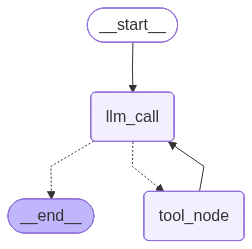

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Y2glfrli3aDPcJeebyyqUbCD)
 Call ID: call_Y2glfrli3aDPcJeebyyqUbCD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

3 + 4 = 7.


In [8]:
# Step 1: Define tools and model

from langchain.tools import tool
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

# load_dotenv()

model = init_chat_model(
    model="gpt-5-nano",
    temperature=0
)

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.
    Args:
        a: First int
        b: Second int
    """
    return a * b
@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.
    Args:
        a: First int
        b: Second int
    """
    return a + b
@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.
    Args:
        a: First int
        b: Second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)
# Step 2: Define state
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

# Step 3: Define model node
from langchain.messages import SystemMessage
def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

# Step 4: Define tool node

from langchain.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Step 5: Define logic to determine whether to end
from typing import Literal
from langgraph.graph import StateGraph, START, END

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
   
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

# Step 6: Build agent
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

from IPython.display import Image, display
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()



In [2]:
llm_calls = messages["llm_calls"]
print(f"Total LLM calls: {llm_calls}")

Total LLM calls: 2


In [3]:
messages  

{'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 246, 'total_tokens': 400, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CdS62wIgayAP5nvqUJHthn6kiL8uo', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--7c7ad9ec-5274-4a80-b9d5-08f4b19701de-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_N9MhAVOHGD2RUt9Gwx4Tzu5N', 'type': 'tool_call'}], usage_metadata={'input_tokens': 246, 'output_tokens': 154, 'total_tokens': 400, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_

In [ ]:
from __future__ import annotations

from typing import Literal, Dict, Any, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt
from langchain.agents import AgentState

# ===== 1. 상태 정의 =====

class BrandProfile(TypedDict, total=False):
    brand_name: str
    category: str
    tone_mood: str
    core_keywords: str
    slogan: str
    target_age: str
    target_gender: str
    avoided_trends: str
    preferred_colors: str

class LogoInfo(TypedDict, total=False):
    logo_id: int
    file_path: str

class TrendContext(TypedDict, total=False):
    """
    트렌드 분석 관련해서 공통으로 쓰일 컨텍스트/캐시.
    - 각 에이전트(브랜드/로고/숏폼)가 트렌드를 호출할 때
      동일한 질의를 반복하지 않도록 캐시 역할도 할 수 있음.
    """
    last_query: Optional[str]      # 마지막으로 분석했던 질의 설명
    last_result_summary: Optional[str]  # 요약 결과(LLM가 만든 자연어)

class ShortformState(AgentState):

    brand_profile: BrandProfile
    user_request: str | None
    # use_trend_research: bool | None

    trend_context: TrendContext
    
    has_logo: bool | None
    logo_candidates: list[LogoInfo] | None
    selected_logo: LogoInfo | None

    veo_prompt: str | None
    local_video_path: str | None
    save_decision: Literal["Y", "N"] | None

# ===== 2. 외부 의존성 (LLM, Veo, DB) — 예시 =====

from google import genai
from google.genai import types
import time
# import cx_Oracle  # Oracle 예시

# veo_client = genai.Client()  # 실제로는 api_key, project 등 설정
DB_DSN = "user/pw@localhost:1521/XEPDB1"  # 예시 DSN

def get_db_connection():
    # 왜 함수로 뺐나? → 노드에서 DB 커넥션 로직을 중복하지 않기 위해.
    return cx_Oracle.connect(DB_DSN)


# trend_agent도 이미 있다고 했으니, 여기서는 래퍼만 정의
def run_trend_agent_for_brand(brand: BrandProfile, extra_prompt: str | None) -> str:
    """
    왜 별도 함수?
    - LangGraph 노드는 state만 알고 있어야하고, 실제 trend_agent 호출 세부 로직은
      함수로 분리해두면 테스트/교체가 쉬움.
    """
    # TODO: 실제 trend_agent.invoke(...)로 교체
    return "2025년 숏폼 트렌드 요약 텍스트 (예시)"


# ===== 3. 노드 함수들 =====

def init_shortform(state: ShortformState) -> Dict:
    """
    시작 노드:
    - 브랜드 프로필이 있는지 확인
    - extra_prompt / use_trend_research를 기본값으로 보정
    """
    if not state.get("brand_profile"):
        return {"error": "브랜드 정보가 없습니다. 먼저 Phase1을 완료해주세요."}
    return {
        "extra_prompt": state.get("extra_prompt") or "",
        "use_trend_research": bool(state.get("use_trend_research"))
    }


def node_trend_agent(state: ShortformState) -> Dict:
    """
    선택 노드:
    - use_trend_research == True일 때만 호출
    - trend_summary에 결과 저장
    """
    if not state.get("use_trend_research"):
        return {}  # 아무것도 안 바꿈

    summary = run_trend_agent_for_brand(
        state["brand_profile"],
        state.get("extra_prompt") or ""
    )
    return {"trend_summary": summary}


def node_check_logo(state: ShortformState) -> Dict:
    """
    DB에서 로고 유무 확인.
    왜 코드를 쓰고 LLM을 안쓰나?
    - 로고 존재 여부는 '사실'이라 LLM 추론이 아니라 DB 질의가 맞음.
    """
    try:
        conn = get_db_connection()
        cur = conn.cursor()
        # 예시: BRAND_LOGO 테이블에서 조회
        cur.execute("""
            SELECT logo_id, file_path
            FROM BRAND_LOGO
            WHERE brand_name = :brand_name
        """, brand_name=state["brand_profile"]["brand_name"])
        rows = cur.fetchall()
    except Exception as e:
        return {"error": f"DB 오류: {e}", "has_logo": False}

    if not rows:
        return {
            "has_logo": False,
            "logo_candidates": []
        }

    logos: list[LogoInfo] = [
        {"logo_id": r[0], "file_path": r[1]} for r in rows
    ]
    return {
        "has_logo": True,
        "logo_candidates": logos
    }


def node_select_logo(state: ShortformState) -> Dict:
    """
    로고 선택 노드 (human-in-the-loop).
    - LangGraph interrupt() 사용해서 사용자 선택을 기다린다.
    """
    if not state.get("has_logo"):
        return {}  # 로고 없으면 아무것도 안함

    # 유저에게 보여줄 정보 (프론트/챗 UI에서 활용)
    selection = interrupt({
        "type": "select_logo",
        "candidates": state.get("logo_candidates", [])
    })
    # selection 예: {"logo_id": 12}
    logo_id = selection["logo_id"]
    selected = next(
        (l for l in state.get("logo_candidates", []) if l["logo_id"] == logo_id),
        None
    )
    return {"selected_logo": selected}


# LLM은 네가 쓰는 OpenAI/Gemini 아무거나 여기서 호출
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage

llm = init_chat_model("gpt-4.1-mini", temperature=0.7)

def node_build_prompt(state: ShortformState) -> Dict:
    """
    Veo용 프롬프트 생성 노드.
    - 브랜드 정보 + (옵션) 트렌드 요약 + extra_prompt + 로고 여부를 종합.
    """
    brand = state["brand_profile"]
    extra = state.get("extra_prompt") or ""
    trend = state.get("trend_summary") or "별도의 트렌드 요약 없음"

    has_logo = bool(state.get("has_logo"))
    logo_hint = "A static logo appears at the end card in the bottom-right corner." if has_logo else \
                "The brand logo style should be softly integrated into the scenes without any existing logo file."

    prompt_template = f"""
You are writing a cinematic 8-second 9:16 short-form video prompt for Google Veo 3.1.

[Brand Info]
- Name: {brand.get("brand_name")}
- Industry: {brand.get("category")}
- Mood: {brand.get("tone_mood")}
- Core Keywords: {brand.get("core_keywords")}
- Slogan: {brand.get("slogan")}
- Target: {brand.get("target_age")} {brand.get("target_gender")}
- Avoided Trends: {brand.get("avoided_trends")}
- Preferred Colors: {brand.get("preferred_colors")}

[Trend Summary]
{trend}

[Additional User Request]
{extra}

[Logo Usage]
{logo_hint}

Write a single, coherent English prompt optimized for Veo 3.1.
Include 3-4 ultra-short shots, clear camera movement, and simple Korean on-screen text only when needed.
    """.strip()

    msg = llm.invoke([HumanMessage(content=prompt_template)])
    return {"veo_prompt": msg.content}


def node_generate_video(state: ShortformState) -> Dict:
    """
    Veo 3.1 호출 노드.
    - has_logo에 따라 image + last_frame 설정 여부가 달라짐.
    - 실제 API 에러나 대기 시간은 여기서 처리.
    """
    prompt = state["veo_prompt"]
    if not prompt:
        return {"error": "veo_prompt가 비어 있습니다."}

    has_logo = bool(state.get("has_logo"))
    config = types.GenerateVideosConfig(
        duration_seconds=8,
        aspect_ratio="9:16",
        resolution="720p"
    )

    if has_logo and state.get("selected_logo"):
        logo_path = state["selected_logo"]["file_path"]
        logo_image = types.Image.from_file(location=logo_path)
        operation = veo_client.models.generate_videos(
            model="veo-3.1-fast-generate-preview",
            prompt=prompt,
            image=logo_image,
            config=config,
        )
    else:
        operation = veo_client.models.generate_videos(
            model="veo-3.1-fast-generate-preview",
            prompt=prompt,
            config=config,
        )

    # 폴링 (간단 예시)
    while not operation.done:
        time.sleep(10)
        operation = veo_client.operations.get(operation)

    video = operation.response.generated_videos[0]
    veo_client.files.download(file=video.video)
    save_path = "outputs/shortform_video.mp4"
    video.video.save(save_path)

    return {"local_video_path": save_path}


def node_confirm_save(state: ShortformState) -> Dict:
    """
    저장 여부를 물어보는 인터럽트 노드.
    - 챗 UI에는 "영상 생성 완료! DB에 저장할까요? (Y/N)" 같은 메시지를 표시.
    """
    if not state.get("local_video_path"):
        return {"error": "저장할 비디오가 없습니다."}

    decision = interrupt({
        "type": "confirm_save",
        "message": "영상 생성이 완료되었습니다. DB에 파일 경로를 저장할까요? (Y/N)"
    })

    # decision 예: {"answer": "Y"} or {"answer": "N"}
    ans = decision.get("answer", "N").upper()
    return {"save_decision": "Y" if ans == "Y" else "N"}


def node_save_to_db(state: ShortformState) -> Dict:
    """
    저장 노드.
    - save_decision == "Y"인 경우에만 Oracle DB에 메타데이터 저장.
    """
    if state.get("save_decision") != "Y":
        return {}

    path = state.get("local_video_path")
    if not path:
        return {"error": "파일 경로가 없습니다."}

    try:
        conn = get_db_connection()
        cur = conn.cursor()
        # 예: SHORTFORM_VIDEO 테이블
        cur.execute("""
            INSERT INTO SHORTFORM_VIDEO (
                brand_name,
                video_path,
                has_logo,
                created_at
            ) VALUES (
                :brand_name,
                :video_path,
                :has_logo,
                SYSTIMESTAMP
            )
        """, brand_name=state["brand_profile"]["brand_name"],
             video_path=path,
             has_logo=1 if state.get("has_logo") else 0)
        conn.commit()
    except Exception as e:
        return {"error": f"DB 저장 실패: {e}"}

    return {}  # 특별히 추가 상태는 없음


# ===== 4. 그래프 빌드 =====

builder = StateGraph(ShortformState)

builder.add_node("init_shortform", init_shortform)
builder.add_node("trend_agent", node_trend_agent)
builder.add_node("check_logo", node_check_logo)
builder.add_node("select_logo", node_select_logo)
builder.add_node("build_prompt", node_build_prompt)
builder.add_node("generate_video", node_generate_video)
builder.add_node("confirm_save", node_confirm_save)
builder.add_node("save_to_db", node_save_to_db)

# --- 엣지 설정 ---

builder.add_edge(START, "init_shortform")
builder.add_edge("init_shortform", "trend_agent")
builder.add_edge("trend_agent", "check_logo")

# check_logo 이후의 분기는 edge_condition으로 구현할 수도 있고
# node 내부에서 다음 노드를 결정하게 해도 됨.
# 여기서는 간단히 "무조건 select_logo로 가고, 거기서 has_logo False면 패스"하는 패턴.
builder.add_edge("check_logo", "select_logo")
builder.add_edge("select_logo", "build_prompt")
builder.add_edge("build_prompt", "generate_video")
builder.add_edge("generate_video", "confirm_save")
builder.add_edge("confirm_save", "save_to_db")
builder.add_edge("save_to_db", END)

checkpointer = MemorySaver()
shortform_graph = builder.compile(checkpointer=checkpointer)

